## Importing Libraries

In [2]:
! pip install imbalanced-learn

     |████████████████████████████████| 167 kB 212 kB/s eta 0:00:01


In [2]:
import imblearn
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn import metrics

## Importing & Inspecting the Dataset

In [3]:
pesacheck_set = pd.read_csv('./kenyan-news/pesa-check.csv')

In [4]:
pesacheck_set['Tag'] = np.nan

In [5]:
pesacheck_set.loc[pesacheck_set.Label == "TRUE", "Tag"] = 0
pesacheck_set.loc[pesacheck_set.Label == "TRUE:", "Tag"] = 0
pesacheck_set.loc[pesacheck_set.Label == "True:", "Tag"] = 0
pesacheck_set.loc[pesacheck_set.Label == "FACT-CHECKED:", "Tag"] = 0
pesacheck_set.loc[pesacheck_set.Label == "Fact", "Tag"] = 0

In [6]:
pesacheck_set.loc[pesacheck_set['Tag'].isnull(), "Tag"] = 1
pesacheck_set.loc[pesacheck_set['Text'].isnull(), "Text"] = " "

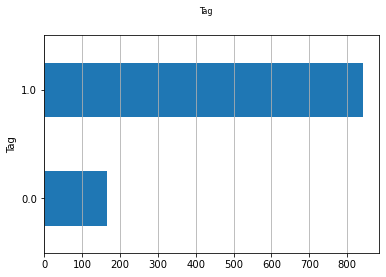

In [7]:
fig, ax = plt.subplots()
fig.suptitle("Tag", fontsize=8)
pesacheck_set["Tag"].reset_index().groupby("Tag").count().sort_values(by= "index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

## Preprocessing

In [8]:
pesacheck_set.head()

,Unnamed: 0,Title,Text,Label,Tag
0,0,This tweet of Kenyan businessman Buzeki critic...,A screenshot shared on Facebook claiming to sh...,FALSE:,1.0
1,1,Joyful Women Organization is not taking loan a...,A claim made on Facebook that the Joyful Women...,HOAX:,1.0
2,2,"This photo of Kenya’s former Prime Minister, R...",A photo shared on Facebook showing former Prim...,ALTERED:,1.0
3,3,This photo does not show men in Nigerian State...,This tweet with an image published on January ...,FALSE:,1.0
4,4,This advertisement for jobs at Café Javas Ugan...,A Facebook post claiming that Café Javas Ugand...,HOAX:,1.0


In [9]:
pesacheck_set['Total'] = pesacheck_set['Title'] + pesacheck_set['Text']
all_data = pesacheck_set.copy()

In [10]:
all_data.loc[:,"Total"] = all_data.Total.apply(lambda x : str.lower(x))

In [11]:
all_data.loc[:,"Total"] = all_data.Total.apply(lambda x : " ".join(re.findall('[\w]+',x)))

In [12]:
all_data.loc[:,"Total"] = all_data.Total.apply(lambda x : "".join(re.sub(r'http\S+', '', x)))

In [13]:
stop_words = get_stop_words('en')

def remove_stopWords(s):
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

all_data.loc[:,"Total"] = all_data.Total.apply(lambda x: remove_stopWords(x))

## Performing Oversampling on the Minority Dataset

In [14]:
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')

In [17]:
x_under = all_data['Total'].to_numpy()
x_under = x_under.reshape(-1, 1)

In [18]:
x_over, y_over = oversample.fit_resample(x_under, all_data['Tag'])

In [19]:
type(all_data['Total'])

pandas.core.series.Series

In [20]:
len(x_under)

1007

In [21]:
len(x_over)

1684

In [22]:
x_data = pd.DataFrame(x_over, columns=['data'])
type(x_data['data'])

pandas.core.series.Series

In [23]:
x_data['data']

0       tweet kenyan businessman buzeki criticising ju...
1       joyful women organization taking loan applicat...
2       photo kenya s former prime minister raila odin...
3       photo show men nigerian state uniformthis twee...
4       advertisement jobs café javas uganda fakea fac...
                              ...                        
1679    supreme court yet deliver ruling tobacco contr...
1680    former zimbabwean president robert mugabe died...
1681    three suspected gang members linked bamburi at...
1682    schools mau will stay open national exams desp...
1683    former president daniel moi dieda tweet claimi...
Name: data, Length: 1684, dtype: object

In [24]:
all_data['Total']

0       tweet kenyan businessman buzeki criticising ju...
1       joyful women organization taking loan applicat...
2       photo kenya s former prime minister raila odin...
3       photo show men nigerian state uniformthis twee...
4       advertisement jobs café javas uganda fakea fac...
                              ...                        
1002    headline northlands city project will cost sh5...
1003    u s embassy security alert bole airport relate...
1004    image daily nation linking jimi wanjigi series...
1005    video ethiopian airlines flight 302 experienci...
1006    former cabinet secretary rashid echesa linked ...
Name: Total, Length: 1007, dtype: object

## Performing Undersampling on the Majority Dataset

In [25]:
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority')

In [26]:
x_new = all_data['Total'].to_numpy()
x_new = x_new.reshape(-1, 1)

In [27]:
x_less, y_less = undersample.fit_resample(x_new, all_data['Tag'])

In [28]:
len(x_new)

1007

In [29]:
len(x_less)

330

In [30]:
x_undersample = pd.DataFrame(x_less, columns=['data'])

## Feature Extraction

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_data['data'], y_over, test_size=0.20, random_state=0)

In [34]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

## Model Training & Testing

In [35]:
logreg = LogisticRegression(C = 1e5, max_iter = 500)
logreg.fit(tfidf_train, y_train)

LogisticRegression(C=100000.0, max_iter=500)

In [36]:
def precision_recall(true_label, predicted_label):
    precision = precision_score(true_label, predicted_label)
    print('Precision: %f' % precision)

    recall = recall_score(true_label, predicted_label)
    print('Recall: %f' % recall)
    
    accuracy = metrics.accuracy_score(true_label, predicted_label)
    print('Accuracy: %f' % accuracy)
    
    f1 = f1_score(true_label, predicted_label)
    print('F1_score: %f' % f1)

In [37]:
predicted_logreg = logreg.predict(tfidf_test)

In [38]:
precision_recall(y_test, predicted_logreg)
cm = confusion_matrix(y_test, predicted_logreg)
cm

Precision: 1.000000
Recall: 0.976608
Accuracy: 0.988131
F1_score: 0.988166


array([[166,   0],
       [  4, 167]])

## Undersampling

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x_undersample['data'], y_less, test_size=0.20, random_state=0)

In [40]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

In [41]:
logreg = LogisticRegression(C = 1e5, max_iter = 500)
logreg.fit(tfidf_train, y_train)

LogisticRegression(C=100000.0, max_iter=500)

In [42]:
predicted_logreg = logreg.predict(tfidf_test)

In [43]:
precision_recall(y_test, predicted_logreg)
cm = confusion_matrix(y_test, predicted_logreg)
cm

Precision: 0.827586
Recall: 0.800000
Accuracy: 0.833333
F1_score: 0.813559


array([[31,  5],
       [ 6, 24]])